In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import cv2
plt.style.use('default')

In [2]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [3]:
import os
def plot_imgs(directory, top=10):
    all_item_dirs = os.listdir(directory)
    item_files = [os.path.join(directory, file) for file in all_item_dirs][:5]
  
    plt.figure(figsize=(20, 20))
  
    for i, img_path in enumerate(item_files):
        plt.subplot(10, 10, i+1)
    
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray') 

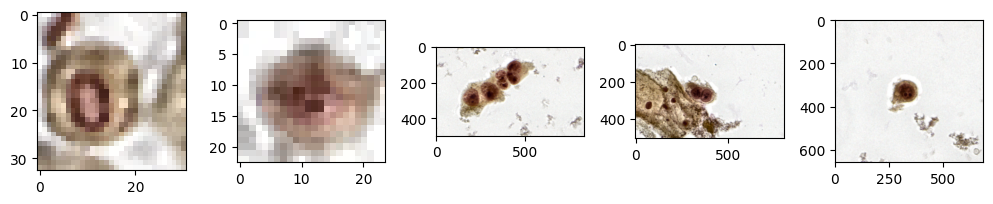

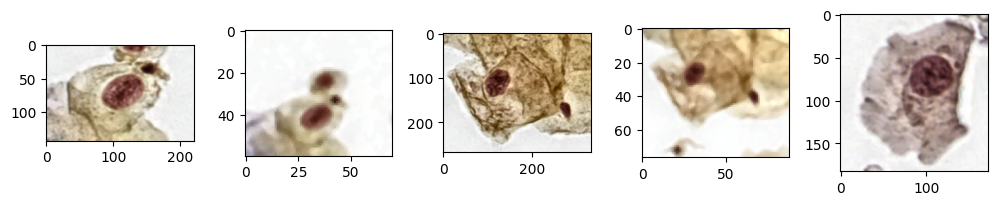

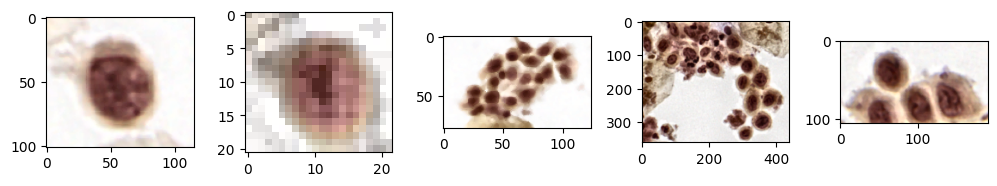

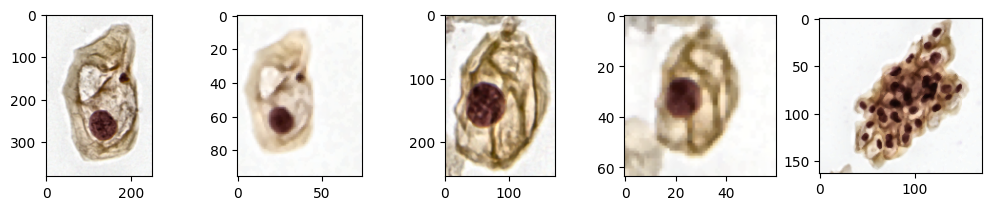

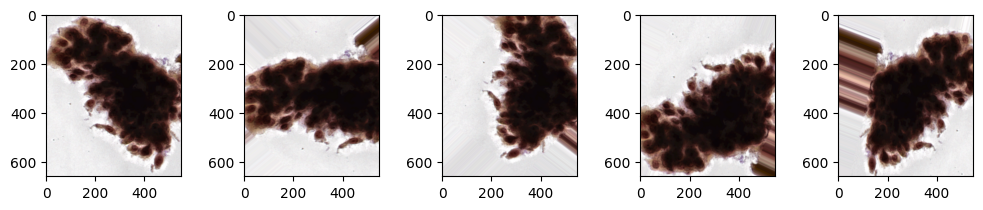

In [4]:
data_path = 'DataProcessed/train/'

directories = ['ASC_H','ASC_US','HSIL','LSIL','SCC'] 

for j in directories:
    plot_imgs(data_path+j)

In [5]:
# def clahe_filter(image):
#     imageRead = cv2.imread(image)
#     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     # Apply median filter
#     image_median = cv2.medianBlur(imageRead, 3)  # Adjust the kernel size as needed
    
#     # Apply CLAHE filter to the median filtered image
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(56, 56))
#     lab = cv2.cvtColor(image_median, cv2.COLOR_RGB2LAB)
#     lab_planes = cv2.split(lab)
#     lab_planes_list = list(lab_planes)
#     lab_planes_list[0] = clahe.apply(lab_planes_list[0])
#     lab = cv2.merge(lab_planes_list)
#     filtered_image = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    
#     return filtered_image

In [3]:
batch_size = 15
train_datagen = ImageDataGenerator(#horizontal_flip = True, 
                                  rescale = 1./255, 
                                  # zoom_range = 0.2,
                                  validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [4]:
Categories=['ASC_H','ASC_US','HSIL','LSIL','SCC'] 
train_data_path = 'DataProcessed/train/'
test_data_path = 'DataProcessed/test/'

train_set = train_datagen.flow_from_directory(train_data_path, target_size = (112,112),
                                              batch_size = batch_size, 
                                              #color_mode = 'rgba',
                                              class_mode = 'categorical',
                                             subset='training',
                                             shuffle="True")

valid_set = train_datagen.flow_from_directory(train_data_path, target_size = (112,112),
                                              batch_size = batch_size, 
                                              #color_mode = 'rgba',
                                              class_mode = 'categorical',
                                             subset='validation',
                                             shuffle="True")

test_set = test_datagen.flow_from_directory(test_data_path, target_size = (112,112),
                                              batch_size = batch_size, 
                                              #color_mode = 'rgba',
                                              class_mode = 'categorical')

Found 13597 images belonging to 5 classes.
Found 1508 images belonging to 5 classes.
Found 712 images belonging to 5 classes.


In [8]:
classes = 5

model = Sequential()
model.add(Conv2D(32, (3,3), padding = 'same', input_shape = (112,112,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(128,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) 

model.add(Flatten())
model.add(Dense(64, activation = 'relu'))

model.add(Dense(32, activation = 'relu'))
model.add(Dense(classes, activation = 'softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [9]:
# import keras
# optimizer1 = keras.optimizers.Adam(learning_rate=0.001)
base_learning_rate = 0.001
model.compile(loss = 'categorical_crossentropy',optimizer = RMSprop(learning_rate=base_learning_rate) , metrics = ['accuracy'])

In [10]:
model_path="saved_models/CNNPre+Aug.h5"
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=3, factor=0.2, min_lr=1e-6)
checkpoint = ModelCheckpoint(model_path, monitor='accuracy', verbose=1, 
                              save_best_only=True, mode='max')

callbacks_list = [checkpoint, reduce_lr]

In [11]:
num_epochs = 15
training_steps=train_set.n//train_set.batch_size
validation_steps =test_set.n//test_set.batch_size

In [12]:
history = model.fit(train_set, epochs=num_epochs, steps_per_epoch=training_steps,validation_data=valid_set,
                    validation_steps=validation_steps, callbacks = callbacks_list)

Epoch 1/15
996/996 [==============================] - ETA: 0s - loss: 1.4262 - accuracy: 0.3606
Epoch 1: accuracy improved from -inf to 0.36063, saving model to saved_models\CNNPre+Aug.h5
996/996 [==============================] - 192s 173ms/step - loss: 1.4262 - accuracy: 0.3606 - val_loss: 1.1882 - val_accuracy: 0.4270 - lr: 0.0010
Epoch 2/15
995/996 [============================>.] - ETA: 0s - loss: 1.2136 - accuracy: 0.4650
Epoch 2: accuracy improved from 0.36063 to 0.46518, saving model to saved_models\CNNPre+Aug.h5
996/996 [==============================] - 75s 75ms/step - loss: 1.2133 - accuracy: 0.4652 - val_loss: 1.0972 - val_accuracy: 0.5234 - lr: 0.0010
Epoch 3/15
996/996 [==============================] - ETA: 0s - loss: 1.1341 - accuracy: 0.5082
Epoch 3: accuracy improved from 0.46518 to 0.50817, saving model to saved_models\CNNPre+Aug.h5
996/996 [==============================] - 71s 71ms/step - loss: 1.1341 - accuracy: 0.5082 - val_loss: 1.0647 - val_accuracy: 0.4950 - l

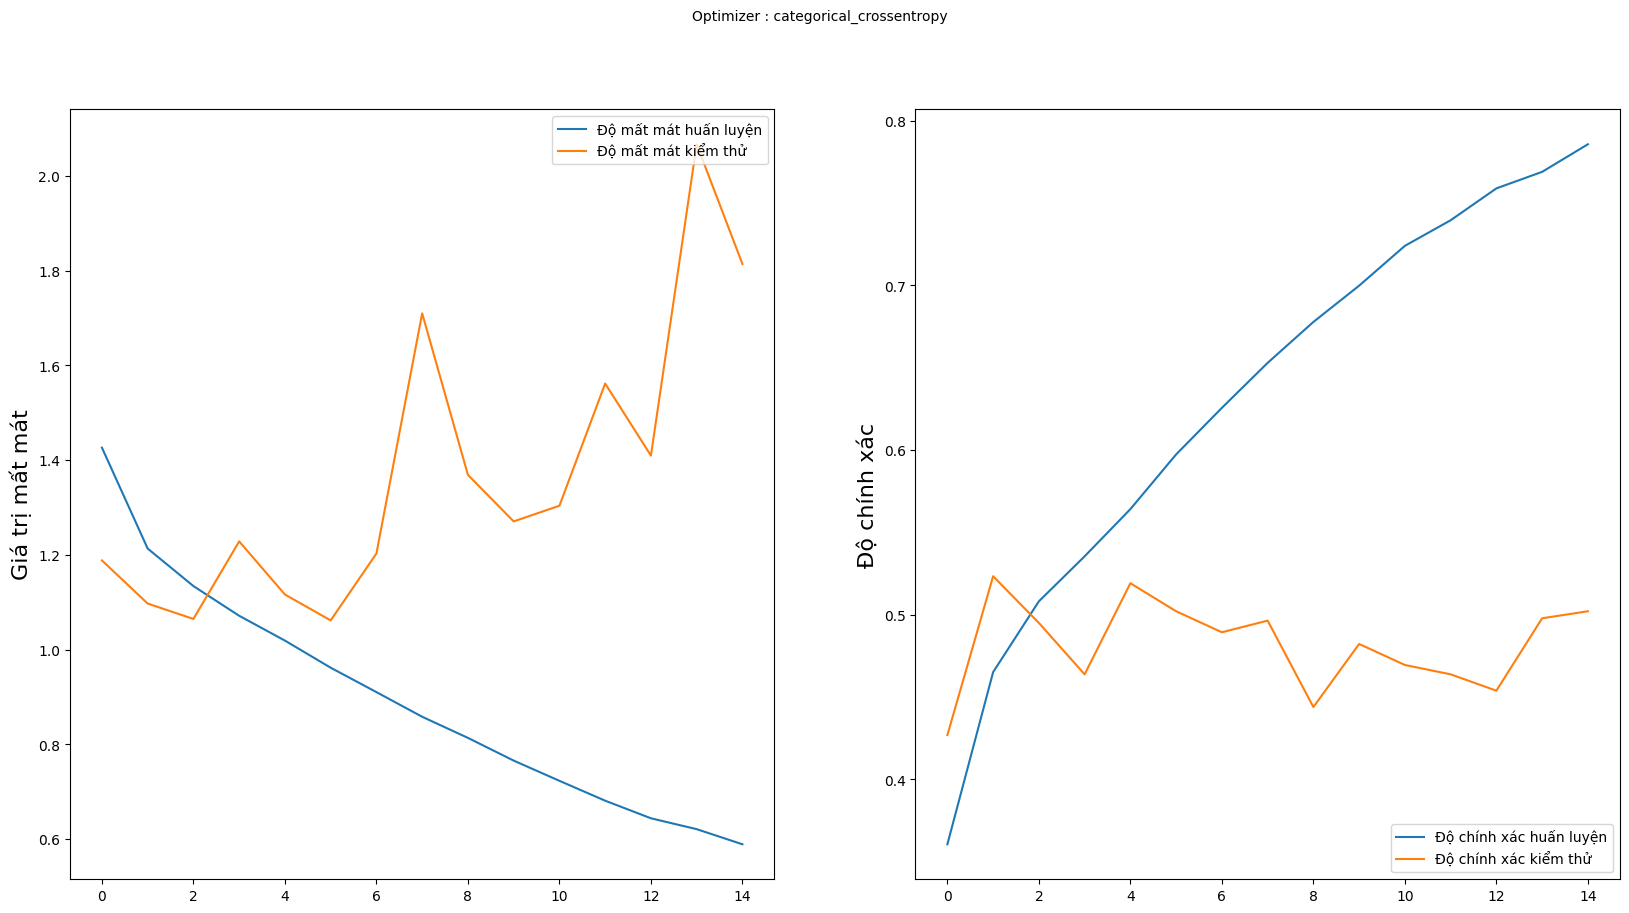

In [15]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : categorical_crossentropy', fontsize=10)
plt.ylabel('Giá trị mất mát', fontsize=16)
plt.plot(history.history['loss'], label='Độ mất mát huấn luyện')
plt.plot(history.history['val_loss'], label='Độ mất mát kiểm thử')
plt.legend(loc='upper right')
plt.subplot(1, 2, 2)
plt.ylabel('Độ chính xác', fontsize=16)
plt.plot(history.history['accuracy'], label='Độ chính xác huấn luyện')
plt.plot(history.history['val_accuracy'], label='Độ chính xác kiểm thử')
plt.legend(loc='lower right')
plt.show()

48/48 [==============================] - 10s 66ms/step
Classification Report:
----------------------
               precision    recall  f1-score   support

       ASC_H       0.26      0.20      0.23       168
      ASC_US       0.23      0.22      0.22       152
        HSIL       0.17      0.15      0.16       128
        LSIL       0.20      0.24      0.22       136
         SCC       0.19      0.23      0.21       128

    accuracy                           0.21       712
   macro avg       0.21      0.21      0.21       712
weighted avg       0.21      0.21      0.21       712



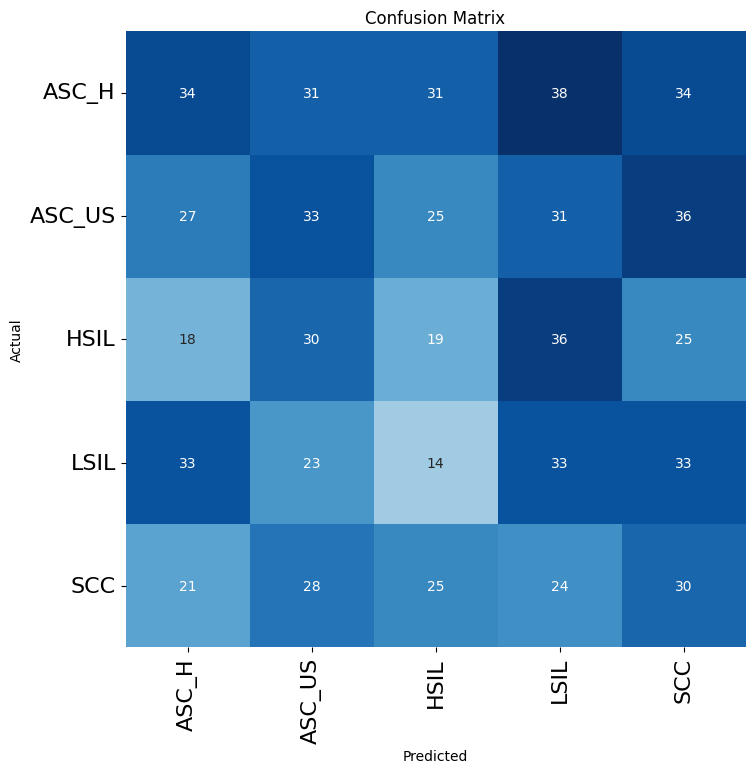

In [5]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
from keras.models import load_model

def cm_cr(test_gen, model):
    preds=model.predict(test_gen)    
    labels=test_gen.labels
    classes=list(test_gen.class_indices.keys()) # ordered lst of class names 
    pred_list=[ ] # will store the predicted classes here
    true_list=[]
    for i, p in enumerate (preds):
        index=np.argmax(p)
        pred_list.append(classes[index])
        true_list.append(classes[labels[i]])
    y_pred=np.array(pred_list)
    y_true=np.array(true_list)
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)
    cm = confusion_matrix(y_true, y_pred )        
    length=len(classes)
    if length<8:
        fig_width=8
        fig_height=8
    else:
        fig_width= int(length * .5)
        fig_height= int(length * .5)
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(length)+.5, classes, rotation= 90, fontsize=16)
    plt.yticks(np.arange(length)+.5, classes, rotation=0, fontsize=16)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

model = load_model('saved_models/CNNPre+Aug.h5')
cm_cr(test_set, model)

48/48 [==============================] - 3s 57ms/step
Classification Report:
----------------------
               precision    recall  f1-score   support

       ASC_H       0.23      0.13      0.17       168
      ASC_US       0.18      0.18      0.18       152
        HSIL       0.21      0.30      0.25       128
        LSIL       0.18      0.24      0.21       136
         SCC       0.19      0.15      0.17       128

    accuracy                           0.20       712
   macro avg       0.20      0.20      0.19       712
weighted avg       0.20      0.20      0.19       712



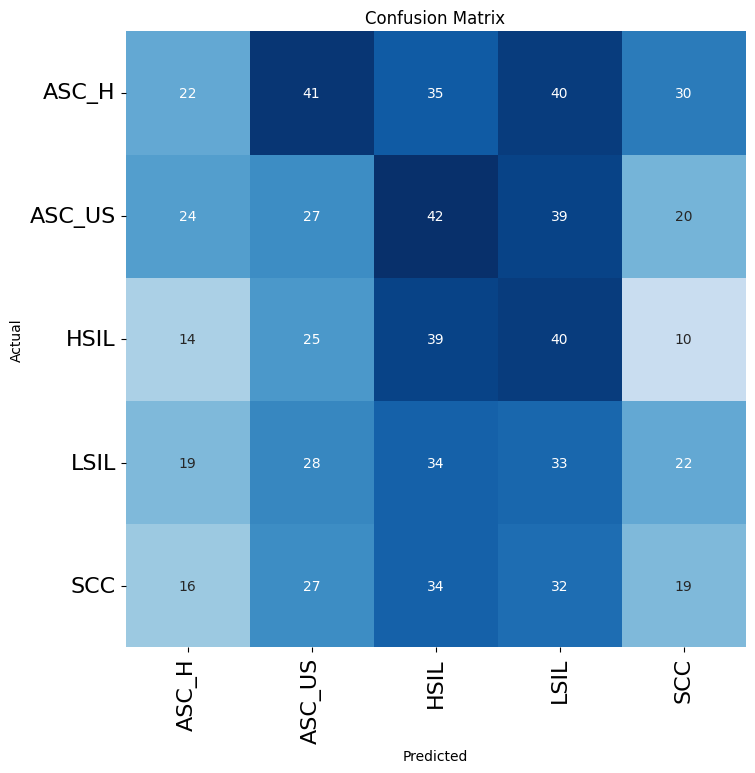

In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
from keras.models import load_model

def cm_cr(test_gen, model):
    preds=model.predict(test_gen)    
    labels=test_gen.labels
    classes=list(test_gen.class_indices.keys()) # ordered lst of class names 
    pred_list=[ ] # will store the predicted classes here
    true_list=[]
    for i, p in enumerate (preds):
        index=np.argmax(p)
        pred_list.append(classes[index])
        true_list.append(classes[labels[i]])
    y_pred=np.array(pred_list)
    y_true=np.array(true_list)
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)
    cm = confusion_matrix(y_true, y_pred )        
    length=len(classes)
    if length<8:
        fig_width=8
        fig_height=8
    else:
        fig_width= int(length * .5)
        fig_height= int(length * .5)
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(length)+.5, classes, rotation= 90, fontsize=16)
    plt.yticks(np.arange(length)+.5, classes, rotation=0, fontsize=16)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

model = load_model('saved_models/CNNPre.h5')
cm_cr(test_set, model)